In [80]:
import os
from nemo.collections.asr.models import EncDecSpeakerLabelModel
from nemo.collections.asr.modules import AudioToMelSpectrogramPreprocessor
from nemo.collections.asr.parts.preprocessing.features import WaveformFeaturizer
import numpy as np
import librosa
import torch
import pickle
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import IPython.display as ipd
%matplotlib inline

In [118]:
# Directory containing real and synthesized samples from various methods for different speakers.
samples_dir = "/home/pneekhara/synthesized_samples/"

In [52]:
wav_paths = {}
for fname in os.listdir(samples_dir):
    if fname.endswith(".wav"):
        wav_type, method_info, speaker, val_no = fname.split("_")
        val_no = val_no.split(".")[0]
        key = "{}_{}_{}".format(wav_type, method_info, speaker)
        if key in wav_paths:
            wav_paths[key].append( ( int(val_no), os.path.join(samples_dir, fname) ) )
        else:
            wav_paths[key] = [ (int(val_no), os.path.join(samples_dir, fname)) ]

for key in wav_paths:
    wav_paths[key].sort()
    wav_paths[key] = [ t[1] for t in wav_paths[key] ]

In [54]:
wav_featurizer = WaveformFeaturizer(sample_rate=44100, int_values=False, augmentor=None)
mel_processor = AudioToMelSpectrogramPreprocessor(
        window_size = None,
        window_stride = None,
        sample_rate=44100,
        n_window_size=2048,
        n_window_stride=512,
        window="hann",
        normalize=None,
        n_fft=None,
        preemph=None,
        features=80,
        lowfreq=0,
        highfreq=None,
        log=True,
        log_zero_guard_type="add",
        log_zero_guard_value=1e-05,
        dither=0.0,
        pad_to=1,
        frame_splicing=1,
        exact_pad=False,
        stft_exact_pad=False,
        stft_conv=False,
        pad_value=0,
        mag_power=1.0
)

speaker_verification_model = EncDecSpeakerLabelModel.from_pretrained("speakerverification_speakernet")
speaker_verification_model.eval().cuda()

[NeMo I 2021-08-09 15:39:53 features:252] PADDING: 1
[NeMo I 2021-08-09 15:39:53 features:269] STFT using torch
[NeMo I 2021-08-09 15:39:53 cloud:56] Found existing object /home/pneekhara/.cache/torch/NeMo/NeMo_1.0.2/speakerverification_speakernet/2202d9ccf2dccac4c87faf6b5507eb9d/speakerverification_speakernet.nemo.
[NeMo I 2021-08-09 15:39:53 cloud:62] Re-using file from: /home/pneekhara/.cache/torch/NeMo/NeMo_1.0.2/speakerverification_speakernet/2202d9ccf2dccac4c87faf6b5507eb9d/speakerverification_speakernet.nemo
[NeMo I 2021-08-09 15:39:53 common:676] Instantiating model from pre-trained checkpoint


[NeMo W 2021-08-09 15:39:53 modelPT:138] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /ws/manifests/raid/combined/train_manifest.json
    sample_rate: 16000
    labels: null
    batch_size: 64
    shuffle: true
    time_length: 8
    augmentor:
      noise:
        manifest_path: /ws/manifests/raid/musan/musan_music_noise_manifest_dur8.json
        prob: 0.2
        min_snr_db: 5
        max_snr_db: 15
    num_workers: 4
    
[NeMo W 2021-08-09 15:39:53 modelPT:145] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath: /ws/manifests/raid/voxceleb/small_manifest.json
    sample_rate: 16000
    labels: null
    batch_size:

[NeMo I 2021-08-09 15:39:53 features:252] PADDING: 16
[NeMo I 2021-08-09 15:39:53 features:269] STFT using torch
[NeMo I 2021-08-09 15:39:53 label_models:90] Training with Angular Softmax Loss
[NeMo I 2021-08-09 15:39:53 modelPT:439] Model EncDecSpeakerLabelModel was successfully restored from /home/pneekhara/.cache/torch/NeMo/NeMo_1.0.2/speakerverification_speakernet/2202d9ccf2dccac4c87faf6b5507eb9d/speakerverification_speakernet.nemo.


EncDecSpeakerLabelModel(
  (preprocessor): AudioToMelSpectrogramPreprocessor(
    (featurizer): FilterbankFeatures()
  )
  (encoder): ConvASREncoder(
    (encoder): Sequential(
      (0): JasperBlock(
        (mconv): ModuleList(
          (0): MaskedConv1d(
            (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), groups=64, bias=False)
          )
          (1): MaskedConv1d(
            (conv): Conv1d(64, 512, kernel_size=(1,), stride=(1,), bias=False)
          )
          (2): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        )
        (res): ModuleList(
          (0): ModuleList(
            (0): MaskedConv1d(
              (conv): Conv1d(64, 512, kernel_size=(1,), stride=(1,), bias=False)
            )
            (1): BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (mout): Sequential(
          (0): ReLU(inplace=True)
          (1): Dropout(p=0.5, inplace=

In [117]:
pickle_path = "/home/pneekhara/synthesized_audio_meta_data.pkl"
regenerate = False
if os.path.exists(pickle_path) and not regenerate:
    with open(pickle_path, "rb") as f:
        meta_data = pickle.load(f)
        embeddings = meta_data['embeddings']
        spectrograms = meta_data['spectrograms']
        pithc_contours = meta_data['pitch_contours']
else:
    embeddings = {}
    spectrograms = {}
    pitch_contours = {}
    for key in wav_paths:
        print ("Getting embeddings for:", key, len(wav_paths[key]))
        embeddings[key] = []
        spectrograms[key] = []
        pitch_contours[key] = []
        for path in wav_paths[key]:
            embedding = speaker_verification_model.get_embedding(path)
            embeddings[key].append(embedding.cpu().numpy().flatten())

            wav = wav_featurizer.process(path)
            mel, _ = mel_processor.get_features(wav[None], torch.tensor([[wav.shape[0]]]).long() )
            mel = mel[0][0].cpu().numpy()

            pitch, _, _ = librosa.pyin(
                wav.numpy(),
                fmin=80,
                fmax=640,
                frame_length=2048,
                sr=44100,
                fill_na=0.0,
            )

            spectrograms[key].append(mel)
            pitch_contours[key].append(pitch)

    with open("synthesized_audio_meta_data.pkl", "wb") as f:
        meta_data = {
            'spectrograms' : spectrograms,
            'pitch_contours' : pitch_contours,
            'embeddings' : embeddings
        }
        pickle.dump(meta_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [56]:
%matplotlib inline
import numpy as np
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pylab as plt
import matplotlib.patches as mpatches
import json

In [113]:
def mscatter(x,y, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    #ax = ax or plt.gca()
    sc = plt.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

def visualize_embeddings(embedding_dict_np, title = "TSNE"):
    # extract num_speakers 10. With new speaker key will have num_speakers+1 speakers in the TSNE plot
    # keys = []
    label_list =[]
    color =[]
    marker_shape = []
    color_idx = 0
    universal_embed_list=[]
    handle_list=[]
    _unique_speakers = {}
    
    marker_list = ['<', '*', 'h', 'X', 's', 'H', 'D', 'd', 'P', 'v', '^', '>', '8', 'p']
    kidx = 0
    
    speaker_keys = {}
    for key in embedding_dict_np:
        wav_type, method_info, speaker = key.split("_")
        if speaker in speaker_keys:
            speaker_keys[speaker].append(key)
        else:
            speaker_keys[speaker] = [key]
    
    _all_keys = []
    for spk in speaker_keys:
        _all_keys += speaker_keys[spk]
        
    for key in _all_keys:
        wav_type, method_info, speaker = key.split("_")
        if method_info == "vocoded":
            continue
        if speaker not in _unique_speakers:
            _unique_speakers[speaker] = len(_unique_speakers)
        
        _num_samples = len(embedding_dict_np[key])
        if speaker in ["92", "6097"]:
            _num_samples = 10 # keeping just 10 to keep things balanced with other speakers
#         print (key, _num_samples)
        universal_embed_list += embedding_dict_np[key][:_num_samples]
        
        #id_color = plt.cm.tab20(_unique_speakers[speaker])
        id_color = plt.cm.tab20(kidx)
        color_element = [id_color] * _num_samples
        color += color_element
        _marker_shape = [ marker_list[kidx % len(marker_list)] ] * _num_samples
        marker_shape += _marker_shape
        _label = "{} : {}".format(key, marker_list[kidx % len(marker_list)])
        handle_list.append(mpatches.Patch(color = id_color, label=_label))
        
        kidx += 1
        
   
    
    speaker_embeddings = TSNE(n_components=2, random_state=0).fit_transform(universal_embed_list)        
    
    #ax = plt.axes()
    #ax.set_facecolor("gainsboro")
    #plt.scatter(speaker_embeddings[:, 0], speaker_embeddings[:, 1], marker = marker_shape,  c=color, s=30)
    mscatter(speaker_embeddings[:, 0], speaker_embeddings[:, 1], m = marker_shape,  c=color, s=60)
   
    plt.legend(handles=handle_list,title="Speaker_ID")
    plt.title(title)
    plt.show()

def plot_pitch(pitch_actual, pitch_synthetic):
    plt.plot(range(len(pitch_actual)), pitch_actual, "r", label = "Real" )
    plt.plot(range(len(pitch_synthetic)), pitch_synthetic, "b", label = "Synthetic" )
    plt.legend()
    plt.title("F0 Pitch contour")
    plt.show()

def visualize_spectrograms_and_pitch(speaker, duration, mixing, n=2):
    actual_key = "real_actual_{}".format(speaker)
    mix_str = "mix" if mixing else "nomix"
    synthesized_key = "synthesized_{}-{}_{}".format(duration, mix_str, speaker)
    
    if duration == "All":
        synth_msg = "trained from scratch on all data audio of speaker {}".format(speaker)
    else:
        synth_msg = "finetuned on {} mins audio of speaker {}".format(duration, speaker)
        if mixing:
            synth_msg += " mixed with 5000 samples of original speaker to create balanced batches."
    
    for idx in range(n):
        actual_spectrogram = spectrograms[actual_key][idx]
        synthetic_spectrogram = spectrograms[synthesized_key][idx]
        
        actual_pitch = pitch_contours[actual_key][idx]
        synthetic_pitch = pitch_contours[synthesized_key][idx]
        
        print ("---"*30)
        print(idx+1, "Actual audio")
        imshow(actual_spectrogram, origin="lower", aspect = "auto")
        plt.show()
        
        ipd.display(ipd.Audio(wav_paths[actual_key][idx]))
        
        
        print(idx+1, "Synthetic audio by model", synth_msg)
        imshow(synthetic_spectrogram, origin="lower", aspect = "auto")
        plt.show()
        ipd.display(ipd.Audio(wav_paths[synthesized_key][idx]))
        
        plot_pitch(actual_pitch, synthetic_pitch)
        

------------------------------------------------------------------------------------------
1 Actual audio


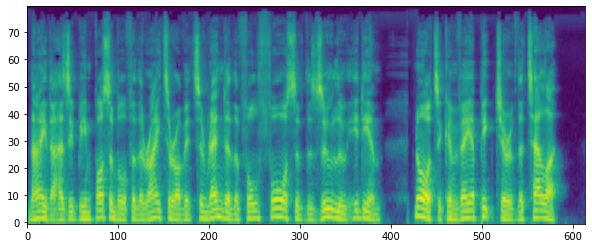

1 Synthetic audio by model trained from scratch on all data audio of speaker 6097


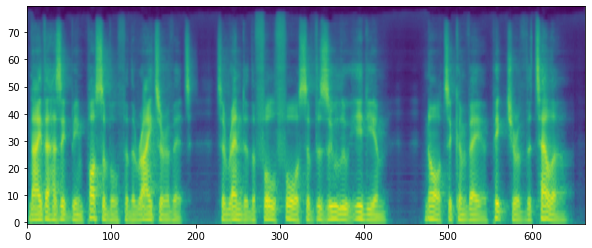

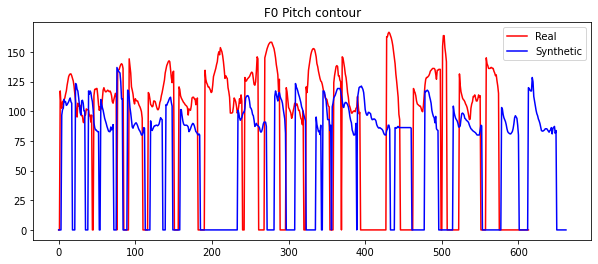

------------------------------------------------------------------------------------------
2 Actual audio


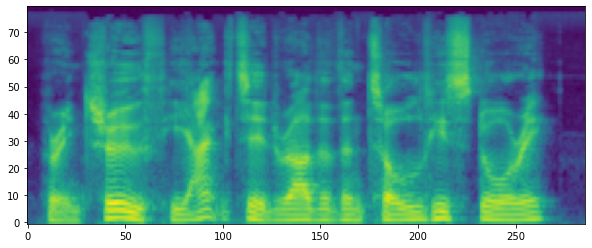

2 Synthetic audio by model trained from scratch on all data audio of speaker 6097


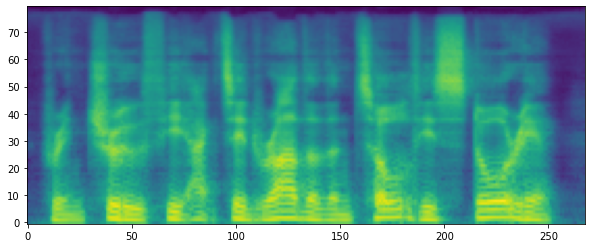

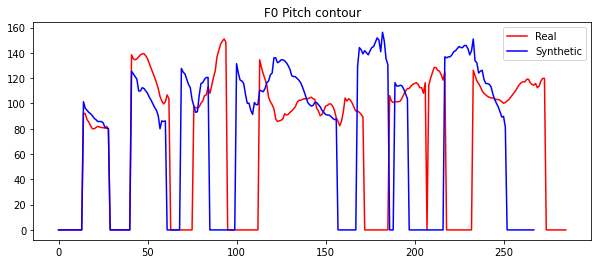

In [114]:
plt.rcParams["figure.figsize"] = (10, 4)
visualize_spectrograms_and_pitch(6097, "All", False)

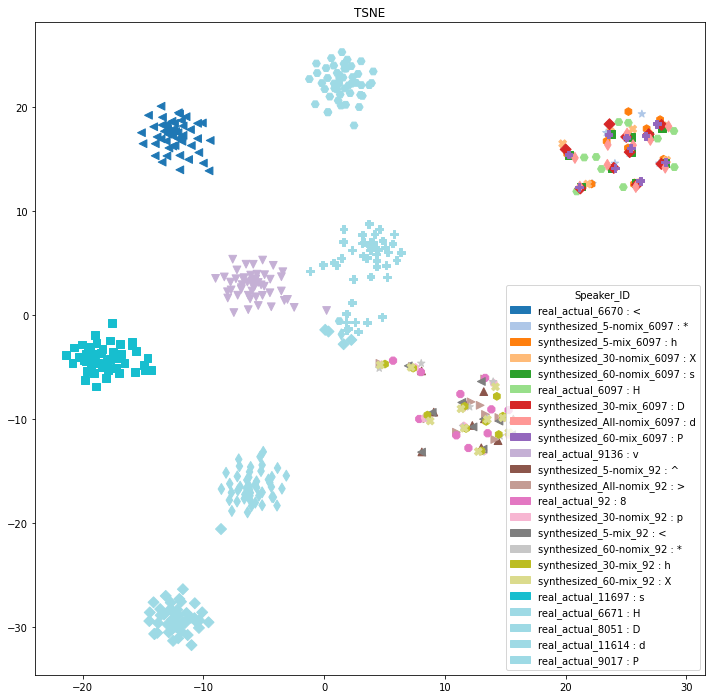

In [115]:
plt.rcParams["figure.figsize"] = (12, 12)
visualize_embeddings(embeddings)